# Amazon stock 'Close' value prediction

In [100]:
import math, time
import datetime as dt

import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import numpy as np

import keras
from keras.initializers import glorot_uniform
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM


In [101]:
%%javascript
//Creating shortcut 'r' to run all the below cells
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('r', {
    help : 'run below cells',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.execute_cells_below();
        return false;
    }}
);

//Creating shortcut 'l' to run all the cells
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('l', {
    help : 'run all cells',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.execute_all_cells();
        return false;
    }}
);

<IPython.core.display.Javascript object>

## Info on pandas_datareader

def DataReader(name, data_source=None, start=None, end=None,
               retry_count=3, pause=0.001, session=None, access_key=None):
    <br><br>
    
    Imports data from a number of online sources.
    Currently supports Yahoo! Finance, Google Finance, St. Louis FED (FRED),
    Kenneth French's data library, and the SEC's EDGAR Index.
    Parameters
    ----------
    name : str or list of strs
        the name of the dataset. Some data sources (yahoo, google, fred) will
        accept a list of names.
    data_source: {str, None}
        the data source ("yahoo", "yahoo-actions", "yahoo-dividends",
        "google", "fred", "ff", or "edgar-index")
    start : {datetime, None}
        left boundary for range (defaults to 1/1/2010)
    end : {datetime, None}
        right boundary for range (defaults to today)
    retry_count : {int, 3}
        Number of times to retry query request.
    pause : {numeric, 0.001}
        Time, in seconds, to pause between consecutive queries of chunks. If
        single value given for symbol, represents the pause between retries.
    session : Session, default None
            requests.sessions.Session instance to be used
    Examples
    ----------
    
    Data from Yahoo! Finance
    gs = DataReader("GS", "yahoo")
    
    Corporate Actions (Dividend and Split Data)
    with ex-dates from Yahoo! Finance
    gs = DataReader("GS", "yahoo-actions")
    
    Data from Google Finance
    aapl = DataReader("AAPL", "google")
    
    Data from FRED
    vix = DataReader("VIXCLS", "fred")
    
    Data from Fama/French
    ff = DataReader("F-F_Research_Data_Factors", "famafrench")
    ff = DataReader("F-F_Research_Data_Factors_weekly", "famafrench")
    ff = DataReader("6_Portfolios_2x3", "famafrench")
    ff = DataReader("F-F_ST_Reversal_Factor", "famafrench")
    
    Data from EDGAR index
    ed = DataReader("full", "edgar-index")
    ed2 = DataReader("daily", "edgar-index")

## Loading Amazon stock data from google.com

In [102]:
stock_name = 'AMZN'
start = dt.datetime(1995,1,1)
end   = dt.date.today()
df = web.DataReader(stock_name, 'google', start, end)
df.to_csv('%s_data.csv'%stock_name, header=True, index=False)
df = pd.read_csv('%s_data.csv'%stock_name)

# Dropping all columns except 'Open','High' and 'Close'
df.drop(['Low','Volume'], axis = 1, inplace=True)
df.head()

,Open,High,Close
0,11.14,11.17,10.46
1,10.58,10.65,9.95
2,10.10,10.30,10.12
3,10.32,11.04,10.53
4,10.54,10.83,10.08


## Normalisation

In [103]:
#Method1 - Division by 10
df = df/(10^(len(str(df.iloc[0,0]).split('.')[0])-1))
#Method2 - Division by 1st value
# df = df/df.iloc[0,0]
df.head()

,Open,High,Close
0,1.012727,1.015455,0.950909
1,0.961818,0.968182,0.904545
2,0.918182,0.936364,0.920000
3,0.938182,1.003636,0.957273
4,0.958182,0.984545,0.916364


In [104]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = int(round(0.9 * result.shape[0]))
    train = result[:row, :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[row:, :-1]
    y_test = result[row:, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

## Building model functions

In [116]:
def build_model(layers):
    d = 0.2
    init = glorot_uniform(seed = 69)

    model = Sequential()
    model.add(LSTM(32, input_shape=(layers[0], layers[1]), return_sequences=True, kernel_initializer = init))
    model.add(Dropout(d))
    model.add(LSTM(32, return_sequences=False, kernel_initializer = init))
    model.add(Dropout(d))
    model.add(Dense(8,kernel_initializer=init ,activation='relu'))        
    model.add(Dense(1,kernel_initializer= init ,activation='linear'))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

## Setting X and Y for training and testing

In [117]:
window = 22
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (3579, 22, 3)
y_train (3579,)
X_test (398, 22, 3)
y_test (398,)


## Loading the model sequence structure

In [118]:
model = build_model([window, 3])

## Executing the model & RMS/RMSE results

In [119]:
stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta= 0.5 , patience=3, verbose=2, mode='auto')
start_time = time.time()

model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_test, y_test),
#     validation_split=0.1,
#     callbacks = [stop],
    verbose = 2)

print('\nTime taken for training: %.2f minutes'%((time.time()-start_time)/60))

Train on 3579 samples, validate on 398 samples
Epoch 1/20
12s - loss: 498.0245 - acc: 2.7941e-04 - val_loss: 0.0409 - val_acc: 0.0025
Epoch 2/20
8s - loss: 184.0424 - acc: 2.7941e-04 - val_loss: 0.1211 - val_acc: 0.0025
Epoch 3/20
8s - loss: 76.7120 - acc: 0.0000e+00 - val_loss: 0.0523 - val_acc: 0.0025
Epoch 4/20
8s - loss: 35.3480 - acc: 2.7941e-04 - val_loss: 0.0578 - val_acc: 0.0025
Epoch 5/20
8s - loss: 18.9509 - acc: 5.5882e-04 - val_loss: 0.1416 - val_acc: 0.0025
Epoch 6/20
8s - loss: 14.5626 - acc: 2.7941e-04 - val_loss: 0.1997 - val_acc: 0.0025
Epoch 7/20
8s - loss: 12.8748 - acc: 5.5882e-04 - val_loss: 0.2313 - val_acc: 0.0025
Epoch 8/20
8s - loss: 12.1128 - acc: 2.7941e-04 - val_loss: 0.0312 - val_acc: 0.0025
Epoch 9/20
9s - loss: 11.5106 - acc: 0.0011 - val_loss: 0.2127 - val_acc: 0.0025
Epoch 10/20
8s - loss: 10.9532 - acc: 0.0011 - val_loss: 0.0366 - val_acc: 0.0025
Epoch 11/20
8s - loss: 10.7260 - acc: 8.3822e-04 - val_loss: 0.0546 - val_acc: 0.0025
Epoch 12/20
9s - loss

In [120]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 2.74 MSE (1.66 RMSE)
Test Score: 0.01 MSE (0.11 RMSE)


In [121]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

## Predictions vs Real results

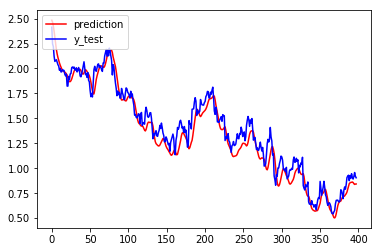

In [122]:
plt.plot(p,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

## Play with the layer sizes to get more accuracy and also check for training time